In [189]:
from sklearn.datasets import load_boston, load_iris
from sklearn.externals.six import StringIO 
import pydot

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.cross_validation import train_test_split, cross_val_score
%matplotlib inline
matplotlib.style.use('ggplot')

# Introduction

In this notebook I'm reviewing heuristics for ranking features in decision trees and random forests, and their implementation in sklearn. In the text I sometimes use variable as a synonym of feature.
Feature selection is a step embedded in the process of growing decision trees. An attractive side effect is that once model is built, we can retrive the relative importance of each feature in the decision making procees. This not only increases the general interpretability of the model, but can help both in exploratory data analysis as well as in feature engineering piepelines. A nice example of how tree based models can be used to improve feature engineering can be found in the winner recap notes of the Criteo Kaggle competition (http://machine-learning-notes.blogspot.nl/2014/12/kaggle-criteo-winner-method-recap.html). 

Tree based models, and ensambles of trees, are very powerful and well understood methods for supervised learning. Ensamles such as Random Forests are roboust and stable methods for both classification and regression, while decision trees allow for conceptually simple and easilly interpretable models. For an overview of tree models in classification and regression in sklean, there is an excellent talk from 
Gilles Louppe at PyData Paris 2015 (http://www.slideshare.net/glouppe/slides-46767187). A well regarded paper from the same author that provides a thorough analysis of the mathematics of feature selection in  tree ensamles is "Understanding variable importances in forests of randomized trees" (Louppe et al. 2014). With this notebook I'm attempting to fill some gaps and bridge literature review to implementation (sklearn).

# Data

I'll be using the Boston dataset (http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html) for regression and the Iris dataset (http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html) for classification examples.

In [190]:
boston = load_boston()
iris = load_iris()

# Tree models for regression and classification

Tree based models are non parametric methods that recursively partition the feature space into rectangular disjoint subsets, and fit a model in each of them. Assuming the space is partitioned in *k* regions, a *regression tree* would predict a response $Y$ given inputs $\bar{X} = \{X_1, X_2, .. X_p\}$ as $$\hat{f}(\bar{X}) = \sum\limits_{m=1}^k c_mI(\bar{X}\in R_m)$$ 
where $I$ is the indicator function and $c_m$ a constant that models $Y$ in region $R_m$.  This model can be represented by a tree that has $R_1..R_m$ as its terminal nodes. In both the regression and classification cases, the algorithm decides the splitting variables and split points, and tree topology. Essentially, at each split point, the algorithm performs a feature selection step using an heuristic to estimate information gain; this is represented by a numerical value known as the *Gini importance* of a feature (not to be confused with the Gini index!).
We can exploit this very same process to rank features (features engineering) and to explain their imporance with regards to the models we want to learn from data.

The main difference between the regression and classification case is the criterion employed to evaluate the quality of a split when growing a tree. Regardless of this aspect, in sklearn, the importance of a variable is calculated as the Gini Importance or "mean decreased impurity" (http://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined). See
"Classification and regression trees" (Breiman, Friedman, 1984).

## Gini importance (MDI) of a variable

Gini importance, or *mean decreased impurity* is defined as the total decrease in node impurity $i(s, n)$, at split $s$ for some impurity function $i(n)$ . That is
$$ \Delta i(s, n) = i(n) - p_L i(t_L) -  p_R i(t_R) $$
Where $p_L$ and $p_R$ are the proportion of $N_L$ and $N_R$ samples in the left and right splits, over the total number of samples $N_n$ for node $n$.

[Under the hood](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/tree/_tree.pyx#L3340), sklearn calculates MDI as follows:

```python
cdef class Tree:
    [...]
    cpdef compute_feature_importances(self, normalize=True):
           [...]
           while node != end_node:
                if node.left_child != _TREE_LEAF:
                    # ... and node.right_child != _TREE_LEAF:
                    left = &nodes[node.left_child]
                    right = &nodes[node.right_child]

                    importance_data[node.feature] += (
                        node.weighted_n_node_samples * node.impurity -
                        left.weighted_n_node_samples * left.impurity -
                        right.weighted_n_node_samples * right.impurity)
                node += 1

        importances /= nodes[0].weighted_n_node_samples
        [...]
```

This method looks at a node and its left, right children. A list of split variables (*node.feature* objects) and the associated importance score is kept in *importance_data*. The node impurity is weighted by the probability of reaching that node,  approximated by the proportion of samples (*weighted_n_node_samples*) reaching that node.

```python
node.weighted_n_node_samples * node.impurity -
left.weighted_n_node_samples * left.impurity -
right.weighted_n_node_samples * right.impurity
```

The *impurity* criteria are defined by implementations of the *Criterion* interface. For classification trees, impurity criteria are *Entropy* - cross entropy - and *Gini*, the Gini index. For regression trees the impurity criteria is *MSE* (mean squared error).

## Regression trees

As said, *sklearn.tree.DecisionTreeRegressor* uses mean squared error (MSE) to determine the quality of a split; that is, an estimate $\hat{c}_m$ for $c_m$ is calcuated so to minimize the sum of squares $\sum (y_i - f(X_i))^2$ with $y_i$ being the target variable and $f(X_i)$ its predicted value. The best (*proof!*) estimator is obtained by taking  $E[y_i]$ in region $X_i \in R_m$. By bias variance decompostion of the squared error , we have $Var[y_i] = E[(y_i - E[y_i])^2]$. So, for a split node, the mean squared error can then be calculated as the sum of variance of the left and right split: $MSE = Var_{left} + Var_{right}$

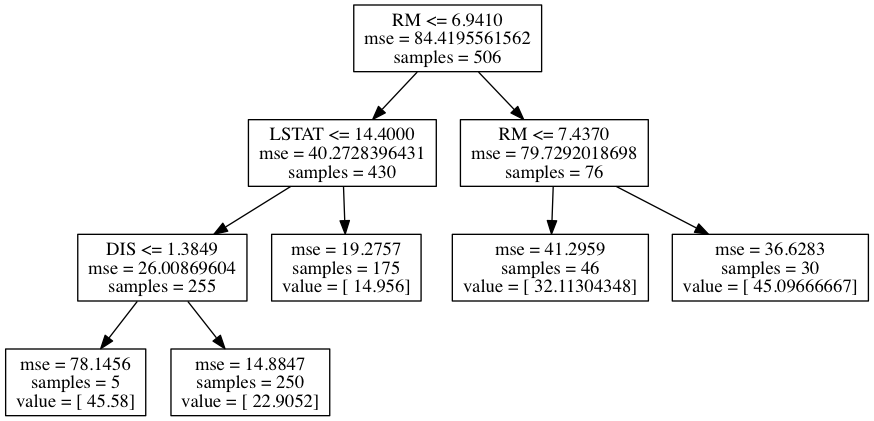

In [92]:
# To keep the diagram tractable, restrict the tree to at most 5 leaf nodes
reg = DecisionTreeRegressor(max_leaf_nodes=5)
reg.fit(boston.data, boston.target)
dot_data = StringIO()
export_graphviz(reg, out_file="/tmp/tree.dot", 
                feature_names=boston.feature_names) 
# pydot.graph_from_dot_data is broken in my env
!dot -Tpng /tmp/tree.dot -o /tmp/tree.png
from IPython.display import Image
Image(filename='/tmp/tree.png')

In the example above, with 5 terminal nodes, we identify three split variables: RM, DIS and LSTAT. For each non terminal node, the diagram shows the split variables and split value, the MSE and the number of datapoints (samples) contained in the resulting partitioned region. Terminal nodes, on the other hand, report the value for the response we want to predict.
We can retrieve the Gini importance of each feature in the fitted model with the *feature\_importances_* property. 

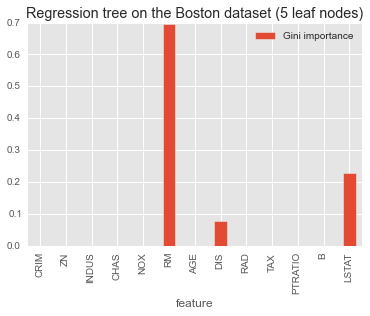

In [179]:
reg = DecisionTreeRegressor(max_leaf_nodes=5)
reg.fit(boston.data, boston.target)
plt = pd.DataFrame(zip(boston.feature_names, reg.feature_importances_),
             columns=['feature', 'Gini importance']).plot(kind='bar', x='feature')
_ = plt.set_title('Regression tree on the Boston dataset (5 leaf nodes)')

Things become a bit more interesting when we grow larger trees.

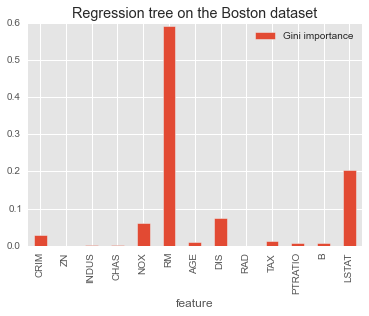

In [180]:
reg = DecisionTreeRegressor()
reg.fit(boston.data, boston.target)
plt = pd.DataFrame(zip(boston.feature_names, reg.feature_importances_), 
             columns=['feature', 'Gini importance']).plot(kind='bar', x='feature')
_ = plt.set_title('Regression tree on the Boston dataset')

## Classification trees

Assume a  classification task where the target $k$ classes take  values in $0,1,...,K−1$. If node $m$ represents a region $R_m$ with $N_m$ observations, then let $p_{mk} = \frac{1}{N_m} \sum_{x_i \in R_m} I(y_i = k)$ be the proportion of class $k$ observations in node $m$. 
$sklearn.DecisionTreeClassifier$ allows two impurity criteria for determining splits in such a setting. On the Iris dataset the two criteria agree on which features are important. Experimental results suggest that for tree induction purposes both impurity measures generally lead to similar results (Tan et. al, Introduction to Data Mining). This is not entirely surprising given that both mesaures are particular cases of Tsallis entropy  $H_\beta = \frac{1}{\beta-1}(1 - \sum_{k=0}^{K-1} p^{\beta}_{mk})$. For Gini index $\beta=2$, while cross entroy is recovered by taking $\beta \rightarrow 1$.

Cross *entropy* might give higher scores to balanced partitions when there are many classes though. See "Technical Note: Some Properties of Splitting Criteria" (Breiman , 1996). On the other hand working in log scale *might* introduce computational overhead.

### Gini Index

Gini Index is defined as $\sum_{k=0}^{K-1} p_{mk} (1 - p_{mk}) = 1 - \sum_{k=0}^{K-1} p_{mk}^2$. It is a measure of statistical dispersion commonly used to measure inequality among values of frequency distributions. An interpretation of the Gini index is popular in social sciences as a way to represent levels of income http://en.wikipedia.org/wiki/Gini_coefficient of a nation's residents. In other words, it is the area under the Lorentz curve (http://en.wikipedia.org/wiki/Lorenz_curve). 

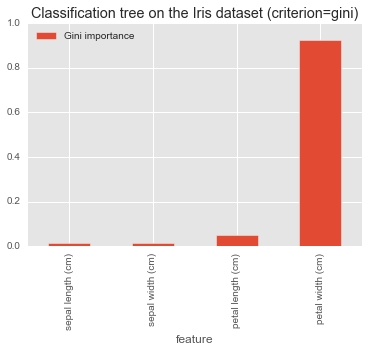

In [187]:
cls = DecisionTreeClassifier(criterion='gini', splitter='best')
est = cls.fit(iris.data, iris.target)
zip(iris.feature_names, cls.feature_importances_)
plt = pd.DataFrame(zip(iris.feature_names, cls.feature_importances_), 
             columns=['feature', 'Gini importance']).plot(kind='bar', x='feature')
_ = plt.set_title('Classification tree on the Iris dataset (criterion=gini)')

### Cross Entropy

Cross-entropy is defined as $- \sum_{k=0}^{K-1} p_{mk} \log(p_{mk})$. Intutively it tells us the amount of information contained at each split node.

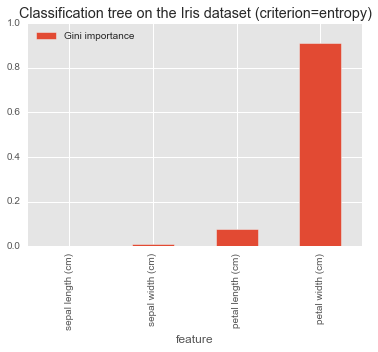

In [185]:
cls = DecisionTreeClassifier(criterion='entropy', splitter='best')
est = cls.fit(iris.data, iris.target)
zip(iris.feature_names, cls.feature_importances_)
plt = pd.DataFrame(zip(iris.feature_names, cls.feature_importances_), 
             columns=['feature', 'Gini importance']).plot(kind='bar', x='feature')
_ = plt.set_title('Classification tree on the Iris dataset (criterion=entropy)')

## Additional parameters

Both DecistionTreeRegressor and DecisionTreeClassifier accept parameters that influence the shape of a tree, hence the topology of the partitioned feature space. These parameters allow to set thresholds to the number of features per split and tree depth. Once the process for growing trees is understood, sklean documentation should be pretty much straightforward. A parameter worth mentionign is *random_state*, that controls the randomization of sampling at each split. If we set this parameter to a constant, we are guaranteed to produce the same splits for each run of the algorithm.

# Ensable methods

Trees lead to very interpretable moodels, which are trivial to visualize. On the one hand this property makes them very attractive as a mean of "communicating" predictive models to a non technical audience. On the other end, they usually result in low bias high variance models. To control variance, we can combine the predictions of several trees into a single model.
At the time of writing sklean ships with two tree ensemble methods: Random Forest (Breiman, 2001) and Extremely Randomized Trees (Geurts et al., 2006).
Both methods extend the ideas of bootstrap aggregation or "bagging" (Breiman 1996), that is sampling a training set with replacement to obtain $m$ datasets (bootstrap sets) and combine the output $m$ models fit on each sampled set.

## Random Forest

Random Forest brings bagging to the feature selection step. $N$ trees are grown on a boostrapped dataset than,
before each split, the algorithm randomly picks $m \leq p$ variables as candidates for splitting. The best candidate is picked according to an heuristic, and the node is split in left/right children. After $N$ such trees are grown, the algorithm combines their predictions. In case of regression trees, this means averaging the output of the ensamlbe of $f$ models as:
$f_{rf}(\bar{X}) = \frac{1}{N} \sum_{n=1}^{N} f_n (\bar{X})$. For classification forests, a common combination strategy is majority voting.
A common value for $m$ is $\sqrt{p}$, the intuition being that small values of $m$ reduce the correlation between pair of trees, hence reduce the variance of the ensemble.

### Regression and classification with Random Forests

*sklearn.ensemble.RandomForestRegressor* and *sklearn.ensemble.RandomForestClassifier* are interaces for building ensembles of DecisionTreeRegressor and  DecisionTreeClassifier respectively. The criteria for determining node impurity are the same as we've seen before: *mse* for regression trees and *gini* or *entropy* for classification trees. The logic for growing and combining the ensemble output is implemented in *sklearn.ensemble.ForestRegressor* and *sklearn.ensemble.ForstClassifier*

### oob_score

Random Forest is known to be a robust classifier that does not overfit; the authors claim no need for cross-validation or even using a test set for model selection (https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#features). An estimate of the generalization error can be obtains as  part of the algorithm run, by leaving out a portion of the bootstrap dataset used for fitting each tree and use it to build a test dataset across the $N$ trees with all data points left out by all trees. That is, but building an out-of-bag test set on the go. This behaviour is controlled by the boolean *oob_score* parameter. On a fitted model, the *oob_score*  argument will then report the error estimate for the ensemble.

In sklearn the out-of-bag error is calculated in *_set_oob_score* in [ForestRegressor](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/ensemble/forest.py#L647) and [ForestClassifier](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/ensemble/forest.py#L362). For regression trees, the oob score is expressed as the sum of the $R^2$ of each predictor on the oob dataset, averaged over the number of predictors. For classification trees, it is the vote given by each predictors *oob_decision_function* that for a forest of $k$ trees is a list of 

```python
decision = (predictions[k] /
                        predictions[k].sum(axis=1)[:, np.newaxis])
```

where *predictions[k]* is the sum of class probabilities predicted by the *predict_proba(X)* method, for some test input $X$, that for a singe tree $k$ is the fraction of samples of the same class in a leaf.

### Intepretability of random forest

With Random Forest we lose the capability visualizing the model as a decision tree diagram. However, we can still  access the feature importance vector for the whole fitted esemble with the *feature\_importances\_* property. This is [computed as](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/ensemble/forest.py#L309)

```python
sum(all_importances) / len(self.estimators_)
```

## Extra trees

sklearn allows for Extremely Randomized Trees to be used instead of Decision Trees to compose an ensemble. I won't cover the working of ExtraTree in this notebook. For a very concise comparison see http://stackoverflow.com/questions/22409855/randomforestclassifier-vs-extratreesclassifier-in-scikit-learn

# Categorical features

In the toy examples above, I've dealt only with numerical features. Fitting models with categorical variables might be a bit confusing if you come from evirnoment like R, where the most common implementations are either able to handle categorical variables natively, or take care of encoding them. In sklearn, a bit more work is necessary to encode categorical variables using eg. Hashing Trick (sklearn.feature_extraction.FeatureHasher) and One-Hot-Encoding (). Alternatively, Pandas provides the convenient DataFrame.get_dummies() method. 

Suprisingly, to me at least, when growing trees on large datasets sklearn behaves well even with integer enconding of categorical features. See https://stackoverflow.com/questions/15821751/how-to-use-dummy-variable-to-represent-categorical-data-in-python-scikit-learn-r and https://github.com/szilard/benchm-ml/issues/1